<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
## This notebook walks us through how to compute a tuning curve using the Allen Brain Observatory data


This notebook has two parts.  The first walks through computing a tuning curves for cells in response to a drifting grating stimulus. This is a classic single-cell analysis, and students can compare the tuning of several cells from the same experiment. The second part looks at correlations between cells that have the same tuning to the drifting grating stimulus from the same experiment. This highlights the fact that our dataset has populations of cells, simultaneously imaged, and allows for examinations of how those cells interact with each other.
This notebook is designed to only reference a single experiment from the Allen Brain Observatory, thus requires only one NWB file to be downloaded. (as downloading NWB files can be time consuming).

### Standard Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import sys, os

### Brain Observatory set up

In [6]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

#Set manifest path when outside of AWS

drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'
manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)

## Computing tuning curve for the drifting grating stimulus

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>We need:

<li>fluorescence trace for our cell.  We will use the DFF trace
<li>stimulus information for the drifting grating stimulus

</div>

In [7]:
cell_id = 541513979

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
I've created a function here that will return the DF/F trace and the stimulus table if we provide a cell id and a stimulus name. This function leverages functions in the AllenSDK, and there are examples that walk through these steps in other notebooks on the SDK page. I'm happy to explain the steps in greater detail if anyone is interested.  
<p>The key things to know about this.  You provide the function with a cell_specimen_id and a stimulus name.  It returns:
<li>the timestamps for the DF/F trace.  This is a numpy array.
<li>the trace of that cell's DF/F trace for the whole session.  This is also a numpy array.
<li>a table that describes the stimulus conditions and timing.  This is a <b>pandas</b> dataframe.
<p> This function can take some time if this is the first time using a specific NWB file, so wait for it to print out "All Done"
</div>

In [8]:
def get_dff_traces_and_stim_table(cell_specimen_id, stimulus): 
    exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], stimuli=[stimulus])
    session_id = exps[0]['id']
    print "Opening NWB file for ophys session. This will take several minutes if the file isn't downloaded yet."
    data_set = boc.get_ophys_experiment_data(session_id)
    print "All Done"
    timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_specimen_id])
    dff_trace = dff[0,:]
    stim_table = data_set.get_stimulus_table(stimulus)
    return (timestamps, dff_trace, stim_table)

In [9]:
timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')

Opening NWB file for ophys session. This will take several minutes if the file isn't downloaded yet.
All Done


In [10]:
timestamps.shape

(115741,)

In [11]:
dff_trace.shape

(115741,)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
First let's plot the DF/F trace of our cell to see what it looks like
</div>

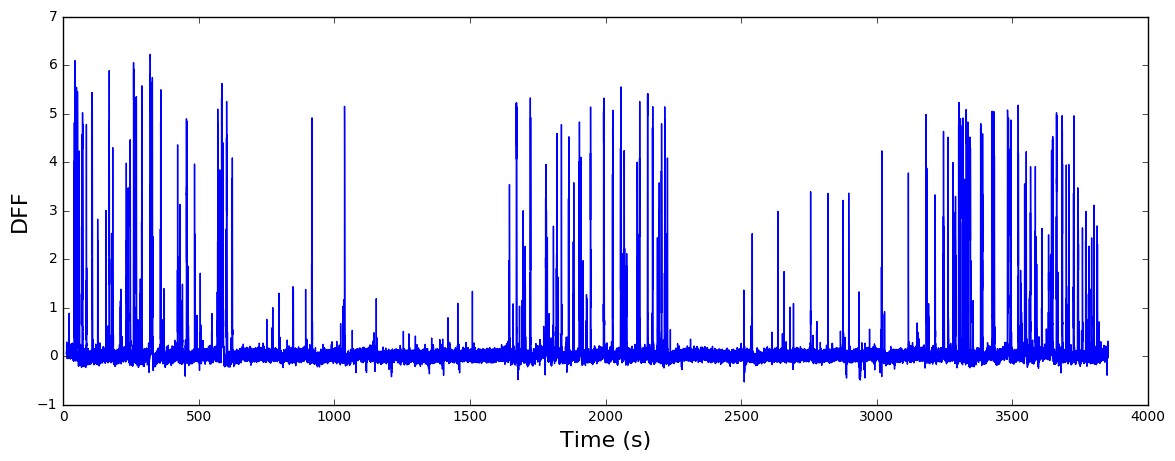

In [12]:
plt.figure(figsize=(14,5))
plt.plot(timestamps, dff_trace)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("DFF", fontsize=16)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Now let's look at our stimulus table to see what information we have. We just want to see the first few lines, so use the function <b>head</b> to see the top of this DataFrame.
</div>

In [15]:
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,735,795
1,15.0,90.0,0.0,825,885
2,1.0,270.0,0.0,916,976
3,NaN,NaN,1.0,1006,1066
4,4.0,90.0,0.0,1097,1157


In [16]:
stim_table.keys()

Index([u'temporal_frequency', u'orientation', u'blank_sweep', u'start',
       u'end'],
      dtype='object')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The stimulus table has 5 columns.  Start and end indicate the <b>frame number</b> when a given grating condition starts and ends, respectively. The other columns indicate what the grating codition is, including the temporal frequency of the grating (in Hz), the direction (called orientation) of the grating (in degrees), and whether the grating is a blank sweep (eg. a gray screen). 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Pandas is a very useful python module for data analysis, which has an object called a <b>DataFrame</b> that is a flexible and powerful tool for analyzing large datasets. I highly encourage interested students to explore this analysis module. But for our purposes, we will only use it to access the stimulus information. 
</div>

## Pandas

<div style="border-radius: 3px; padding: 10px;  background: #F0FAFF; ">
<b>Quick pandas tutorial for our purposes today!</b>
<p>
To access data from a DataFrame we must specify the column we are using and specify the row using the <b>index</b>. To specify a column we can use two methods:
<li> stim_table['start']
<li> stim_table.start
<p> Then to specify the row we want we must use the index of that row. 
<li> stim_table['start'][0]
<li> stim_table.start[0]
<p> We can also subselect portions of the DataFrame using the values in the DataFrame. For example, to select only the rows of the table where the orientation is 90 degrees we can use:
<li> stim_table[stim_table.orientation==90]
<p>Try this yourself.  Note the index.  The rows of this subselected DataFrame maintain the indices of the original DataFrame. Now in order to get a specific row, you either need to know it's original index, or use <b>iloc</b>. For example, this will return the first row of the subselected DataFrame regardless of the original index of that row:
<li> stim_table[stim_table.orientation==90].iloc[0]
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
To look at the cell's response to a given grating presentation, let's plot the DF/F of the cell during the presentation of that grating.  We want to pad the plot with ~ 1 second of the DF/F trace preceding the grating presentation.  1 second = 30 frames.  We'll plot the response to the first grating presentation.
<div>

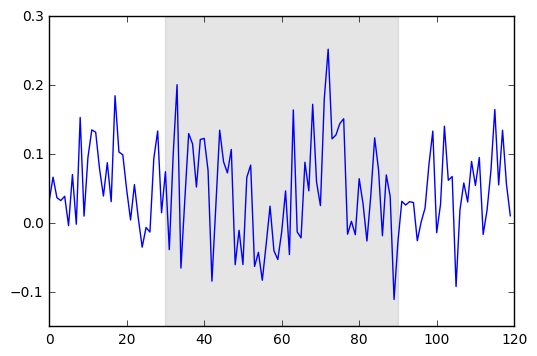

In [19]:
plt.plot(dff_trace[stim_table.start[0]-30:stim_table.end[0]+30])
plt.axvspan(30,90, color='gray', alpha=0.2)

In [ ]:
plt.plot(dff_trace[stim_table.start[0]-30:stim_table.end[0]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

We want to quantify this response. We can explore different methods of quantifying this.
* mean DF/F during the grating presentation
* sum of the DF/F during the grating presentation (are these different?)
* maximum DF/F during grating

For now let's use the mean DF/F during the presentation of the grating.

In [22]:
dff_trace[stim_table.start[0]:stim_table.end[0]].mean()

0.045773286

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 1:** Repeat this for the next grating stimulus </div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
So already we can see that some stimulus conditions elicit larger responses than others.  This is what we want to quantify. 

<p><p>To do this, let's calculate the mean DF/F for each grating presentation in this stimulus. To start, let's create a numpy array to hold our calculated responses. We'll have three columns, one for the stimulus orientation, one for temporal frequency, and the last for the response. Then we need to iterate over all stimulus trials, populate the orientation and TF and then calculate the mean response.
</div>

In [24]:
stim_table.shape

(628, 5)

In [26]:
response = np.empty((628,3))
for i in range(len(stim_table)):
    response[i,0] = stim_table.orientation[i]
    response[i,1] = stim_table.temporal_frequency[i]
    response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
If we only care about one stimulus parameter, we can quickly compare the response to that parameter, say the direction. Here we will plot each grating response as a function of the grating orientation.
</div>

(-10, 325)

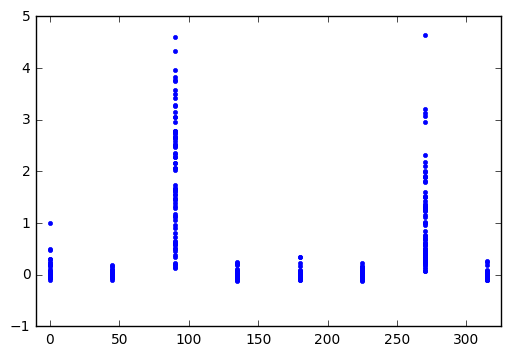

In [28]:
plt.plot(response[:,0], response[:,2], '.')
plt.xlim(-10,325)

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 2:** Repeat this for the temporal frequency parameter </div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
We want to quantify this more explicitly.  So let's average all of the responses to each orientation together. This is the mean DF/F response to an orientation, for all temporal frequencies, for all trials.  For example, for orientation=270: (Hint: use np.where)
</div>

In [ ]:
trials = np.where(cell_response[:,0]==270)[0]
cell_response[trials,2].mean()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 3:** Compute the mean response as a function of orientation
<p> To start, you need to know what all the possible orientation values are. You can either find this from the website, or you can find the <b>unique</b> values that are not NaNs (eg. values that are <b>finite</b>)
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 4:** Compute the mean response as a function of temporal frequency for all orientations. </div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 5:** Add errorbars to the above tuning curves. They can be standard deviation or standard error or the mean.  (Hint: plt.errorbar might be a useful function).
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
**Exercise 6:** Add a black line showing the mean response to the blank sweep (Hint 1: orientation and temporal frequency are NaN for the blank sweep condition.  Hint 2: plt.axhline might be a useful function).  </div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 7:** Compute and plot the direction tuning curve separately for each of the 5 temporal frequencies. </div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 8:** Are there other ways to visualize these tuning responses? </div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 9: HOMEWORK DUE MONDAY** 
Compute the tuning curves for cell_ids 541512490, 541512611, 541512645, 541512079, 541511403, 541511670, 541511373, 541511385, 541512607. (Hint: it might be helpful to write a function) In what ways do these tuning curves differ? In what ways are they the same? What are interesting parameters of a cell's response to this stimulus? </div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Some of these cells show the same tuning for orientation and temporal frequency. In this second part of our notebook, let's look at these more closely to see how they are correlated.

<p>If you've overwritten the dff_trace, go back and get the trace for our original cell: cell_id = 541513979
<p>Also get the trace for cell 541511385, let's call this trace "dff_trace_2"
</div style>

In [ ]:
cell_id = 541513979
timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')

In [ ]:
new_cell_id = 541511385
timestamps, dff_trace_2, stim_table = get_dff_traces_and_stim_table(new_cell_id, 'drifting_gratings')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
These two cells have the same tuning preferences, but how similar are their responses?
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 10:** Compute the correlation between these two cells' traces
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 11:** Calculate the response of the second cell to all the stimulus trials and compute the correlation between these two cells' responses.
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 12:** Calculate the orientation tuning curve for the second cell and compute the correlation between these two cells' tuning.
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 13:** Plot the responses of the two cells to their shared preferred condition (cell 2 vs cell 1) and compute the correlation between those responses.
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
**Exercise 14:** This is the correlation between the response to each of the trials of the preferred grating condition. What about the correlation between the mean response to that condition?
For each cell, make a numpy array of the dff trace during the preferred grating presentation, including 1 second before and 1 second after. There are 15 trials for each condition. (Hint: the stimulus is presented for ~60 frames (=2 seconds), but it is sometimes 59, sometimes 61. To make life easier, assume a stimulus presentation of 60 frames.)
Plot the responses of the two cells on the same plot. Are they similar?  Compute the correlation coefficient of these two traces.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
These cells have strong correlation between the tuning curves as well as between their mean response to the preferred condition, but their responses to the 15 trials of their prefered condition are completely uncorrelated. What does that mean?
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 15:** Cell 541511373 has the same tuning preferences as these two cells do.  Repeat this correlation analysis comparing our first cell with this cell and the second cell with this cell.  
</div>